# CI/CD Simulation — Evidence Bundle as a Build Artifact

This notebook simulates what a CI job would do:

1. run scans
2. compute risk
3. gate
4. produce an evidence bundle
5. verify bundle integrity

## GDrive Setup

In [1]:
import os, pathlib, subprocess
from  google.colab import drive
if not os.path.exists("/content/drive"):
    drive.mount('/content/drive')
else:
  print("Drive already mounted")

search_item = '01_Quickstart_Evidence_Pipeline.ipynb'

l_result_labels = subprocess.run(["find","/content/drive/MyDrive","-type","f","-iname",f"*{search_item}*"],capture_output=True, text=True)
print(f"Labels_proj.csv path: {l_result_labels.stdout.splitlines()}")

Mounted at /content/drive
Labels_proj.csv path: ['/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/notebooks/01_Quickstart_Evidence_Pipeline.ipynb']


In [2]:
%cd /content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline

!pip -q install -r requirements.txt
!pip -q install -e .

/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dspm-devsecops (pyproject.toml) ... done


## 1) Run pipeline in 'ci' mode

In [3]:
import shutil, pathlib
out = pathlib.Path("_ci_out")
if out.exists():
    shutil.rmtree(out)
out.mkdir(parents=True, exist_ok=True)

!python -m dspm_devsecops.cli --repo-root . ci --out _ci_out

                    DSPM + DevSecOps Pipeline Summary (v1.1)                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Category            ┃ Count ┃ Notes                                          ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Terraform findings  │     2 │ IaC posture + network/iam/serverless patterns  │
│ Serverless findings │     7 │ Triggers, env leakage, VPC attachment, logging │
│ Base Risk (0-100)   │    60 │ From IaC findings (demo)                       │
│ Policy Gate         │  FAIL │ Policy DSL evaluated against normalized assets │
│ Artifacts           │     - │ Wrote outputs to                               │
│                     │       │ /content/drive/MyDrive/DSPM-DevSecOps-Ephemer… │
└─────────────────────┴───────┴────────────────────────────────────────────────┘


### Checking for `tenants.yml`

Before modifying the `repo-root` argument, let's confirm if the `tenants.yml` file exists within the current working directory's `examples/tenancy` subfolder. This check will help ensure the `repo-root` is correctly set to point to the project's root.

In [4]:
import pathlib

project_root = pathlib.Path.cwd()
tenants_yml_path = project_root / "examples" / "tenancy" / "tenants.yml"

if tenants_yml_path.exists():
    print(f"'tenants.yml' found at: {tenants_yml_path.as_posix()}")
    print("It seems the 'repo-root' should be '.' (current directory).")
else:
    print(f"'tenants.yml' NOT found at: {tenants_yml_path.as_posix()}")
    print("Searching the entire project directory for 'tenants.yml'...")
    search_results = list(project_root.rglob("tenants.yml"))
    if search_results:
        print("Found 'tenants.yml' at the following locations:")
        for p in search_results:
            print(f"- {p.as_posix()}")
    else:
        print("Could not find 'tenants.yml' anywhere in the project directory. You might need to create it or ensure it's in the correct location.")


'tenants.yml' found at: /content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/examples/tenancy/tenants.yml
It seems the 'repo-root' should be '.' (current directory).


## 2) Check CI outputs

In [5]:
import pathlib
out = pathlib.Path("_ci_out")
for p in sorted(out.rglob("*")):
    if p.is_file():
        print(p.relative_to(out).as_posix())

destroy_closure.json
evidence/manifest.sha256.json
evidence/receipt_audit.json
evidence/receipt_create.json
evidence/receipt_destroy.json
evidence/receipt_maintain.json
gate_status.json
normalized_assets.json
policy_results.json
risk_score_base.json
scans/serverless_findings.json
scans/terraform_findings.json
trigger_graph.json


## 3) Verify evidence integrity

In [6]:
import json, pathlib, hashlib

manifest_path = pathlib.Path("_ci_out/evidence/manifest.sha256.json") # Corrected filename
manifest = json.loads(manifest_path.read_text())

def sha256_file(path: pathlib.Path) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        for chunk in iter(lambda: f.read(1024*1024), b""):
            h.update(chunk)
    return h.hexdigest()

base = manifest_path.parent
bad = []
for item in manifest["entries"]:
    rel = item["path"]
    expected = item["sha256"]
    actual = sha256_file(base / rel)
    if actual != expected:
        bad.append(rel)

print("Integrity:", "PASS" if not bad else "FAIL")
bad[:10]

Integrity: PASS


[]

## 4) Attach artifacts in GitHub Actions

In `.github/workflows/ci.yml`, upload `_ci_out/` (or `evidence/`) as an artifact.

This produces a portable proof bundle for **AUDIT** and **DESTROY** phases.

In [7]:
import json
import pathlib

manifest_path = pathlib.Path("_ci_out/evidence/manifest.sha256.json")
manifest_content = json.loads(manifest_path.read_text())

# Pretty-print the JSON content
print(json.dumps(manifest_content, indent=2))

{
  "entries": [
    {
      "path": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/_ci_out/scans/serverless_findings.json",
      "sha256": "8799495659c041295cab8d595543c7460ef96e11e323edb73f9b73473c767da8",
      "bytes": 2508
    },
    {
      "path": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/_ci_out/scans/terraform_findings.json",
      "sha256": "9d8c4e68723bba7b7f2ce668e7d054681adc7cc026890c14fef5d52342c18764",
      "bytes": 1091
    },
    {
      "path": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/_ci_out/trigger_graph.json",
      "sha256": "477cd4f71abd49318d86d65356d042ba96f17d334336e2266ae1a52f371eaee4",
      "bytes": 499
    },
    {
      "path": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/_ci_out/risk_score_base.json",
      "sha256": "fe2fb35e3eac718b9d13aa83f2277474e4dc50416636a71bde156f434cfd266b",
      "bytes": 107
    },
    {
      "path": "/conten

In [8]:
import json
import pathlib

terraform_findings_path = pathlib.Path("_ci_out/scans/terraform_findings.json")

if terraform_findings_path.exists():
    findings_content = json.loads(terraform_findings_path.read_text())
    print(json.dumps(findings_content, indent=2))
else:
    print(f"Error: File not found at {terraform_findings_path.as_posix()}")

[
  {
    "file": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/examples/iac/terraform/main.tf",
    "resource_type": "aws_lambda_function",
    "name": "demo_fn",
    "severity": "MEDIUM",
    "message": "Lambda function appears not VPC-attached (ephemeral egress harder to bound)",
    "evidence": {
      "attrs": {
        "function_name": "\"demoFn\"",
        "handler": "\"index.handler\"",
        "runtime": "\"python3.11\"",
        "role": "\"aws_iam_role.lambda_exec.arn\""
      }
    }
  },
  {
    "file": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/examples/iac/terraform/main.tf",
    "resource_type": "aws_lambda_permission",
    "name": "demo_invoke",
    "severity": "CRITICAL",
    "message": "Lambda invoke permission appears wildcarded (principal='*')",
    "evidence": {
      "attrs": {
        "statement_id": "\"AllowExecutionFromAnywhere\"",
        "action": "\"lambda:InvokeFunction\"",
        "function_name": "a

### Analysis of `scans/serverless_findings.json`

The `scans/serverless_findings.json` file reveals several security and configuration findings related to the serverless functions defined in `/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/examples/iac/serverless/serverless.yml`.

**High Severity Findings:**
*   **Potential secret-like keys in function environment (`ingest` function):** The `API_KEY` is present in the environment, suggesting sensitive information might be exposed. It's recommended to use a secrets manager for these. This is a critical security vulnerability.
*   **HTTP-triggered function (`api` function):** The API endpoint `/risk` triggered by HTTP should be treated as a public invocation surface unless tight authorization is in place. This indicates a potential exposure.

**Medium Severity Findings:**
*   **Event-triggered function (`ingest` function) with S3 event:** Requires ensuring least-privilege access and allowlisting of event sources for security.
*   **Function not VPC-attached (`ingest` and `api` functions):** Lack of VPC attachment means egress is less CIDR-bounded, potentially increasing the attack surface for outbound connections.

**Low Severity Findings:**
*   **Provider logging not explicitly configured (`ingest` and `api` functions):** Logging is not explicitly set up, which can hinder auditing and incident response. Explicit configuration for retention and redaction policies is recommended.

In summary, the serverless scan identified issues ranging from critical secret exposure and public API exposure to recommended best practices for logging and network configuration. These findings are crucial for improving the security posture of the serverless application.

In [9]:
import json
import pathlib

serverless_findings_path = pathlib.Path("_ci_out/scans/serverless_findings.json")

if serverless_findings_path.exists():
    findings_content = json.loads(serverless_findings_path.read_text())
    print(json.dumps(findings_content, indent=2))
else:
    print(f"Error: File not found at {serverless_findings_path.as_posix()}")


[
  {
    "file": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/examples/iac/serverless/serverless.yml",
    "function": "ingest",
    "severity": "MEDIUM",
    "message": "Event-triggered function: ensure least-privilege + event source allowlist",
    "evidence": {
      "event": {
        "s3": {
          "bucket": "demo-bucket",
          "event": "s3:ObjectCreated:*"
        }
      }
    }
  },
  {
    "file": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/examples/iac/serverless/serverless.yml",
    "function": "ingest",
    "severity": "HIGH",
    "message": "Potential secret-like keys in function environment (use secrets manager + runtime fetch)",
    "evidence": {
      "environment_keys": [
        "API_KEY"
      ]
    }
  },
  {
    "file": "/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/examples/iac/serverless/serverless.yml",
    "function": "ingest",
    "severity": "LOW",
    "message": "Prov

In [10]:
import pandas as pd
import json
import pathlib

serverless_findings_path = pathlib.Path("_ci_out/scans/serverless_findings.json")

if serverless_findings_path.exists():
    with open(serverless_findings_path, 'r') as f:
        serverless_findings_data = json.load(f)

    df_serverless_findings = pd.DataFrame(serverless_findings_data)
    print("DataFrame loaded successfully. Displaying the first 5 rows:")
    display(df_serverless_findings.head())
else:
    print(f"Error: File not found at {serverless_findings_path.as_posix()}")

DataFrame loaded successfully. Displaying the first 5 rows:


,file,function,severity,message,evidence
0,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,ingest,MEDIUM,Event-triggered function: ensure least-privile...,"{'event': {'s3': {'bucket': 'demo-bucket', 'ev..."
1,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,ingest,HIGH,Potential secret-like keys in function environ...,{'environment_keys': ['API_KEY']}
2,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,ingest,LOW,Provider logging not explicitly configured; en...,{'provider_logs': {}}
3,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,ingest,MEDIUM,Function not VPC-attached: egress is less CIDR...,{}
4,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,api,HIGH,HTTP-triggered function: treat as public invoc...,"{'event': {'http': {'path': '/risk', 'method':..."


In [11]:
severity_counts = df_serverless_findings['severity'].value_counts().reset_index()
severity_counts.columns = ['severity', 'count']
display(severity_counts)

,severity,count
0,MEDIUM,3
1,HIGH,2
2,LOW,2


In [12]:
high_findings = df_serverless_findings[df_serverless_findings['severity'] == 'HIGH']
display(high_findings)

,file,function,severity,message,evidence
1,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,ingest,HIGH,Potential secret-like keys in function environ...,{'environment_keys': ['API_KEY']}
4,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,api,HIGH,HTTP-triggered function: treat as public invoc...,"{'event': {'http': {'path': '/risk', 'method':..."


In [13]:
critical_findings = df_serverless_findings[df_serverless_findings['severity'] == 'CRITICAL']
display(critical_findings)

,file,function,severity,message,evidence


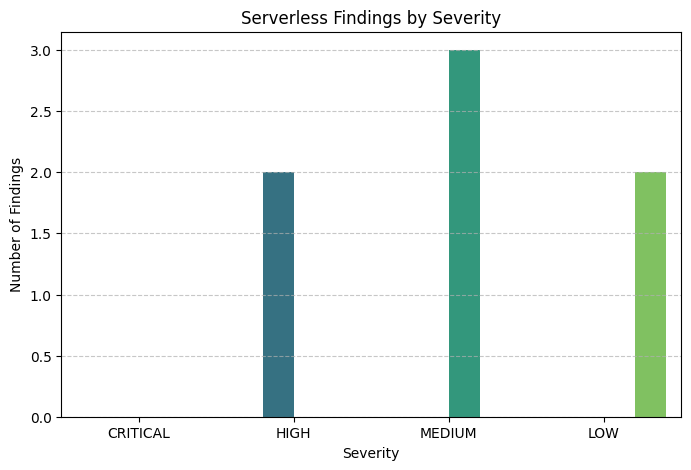

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each severity level
severity_counts = df_serverless_findings['severity'].value_counts().reset_index()
severity_counts.columns = ['severity', 'count']

# Define a custom order for severity for better visualization
severity_order = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
severity_counts['severity'] = pd.Categorical(severity_counts['severity'], categories=severity_order, ordered=True)
severity_counts = severity_counts.sort_values('severity')

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='severity', y='count', hue='severity', data=severity_counts, palette='viridis', legend=False)
plt.title('Serverless Findings by Severity')
plt.xlabel('Severity')
plt.ylabel('Number of Findings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
display(df_serverless_findings.describe())

,file,function,severity,message,evidence
count,7,7,7,7,7
unique,1,2,3,5,5
top,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,ingest,MEDIUM,Provider logging not explicitly configured; en...,{'provider_logs': {}}
freq,7,4,3,2,2


In [16]:
df_serverless_findings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   file      7 non-null      object
 1   function  7 non-null      object
 2   severity  7 non-null      object
 3   message   7 non-null      object
 4   evidence  7 non-null      object
dtypes: object(5)
memory usage: 412.0+ bytes


### Analysis of `scans/terraform_findings.json`

The `scans/terraform_findings.json` file shows two findings related to your Terraform configuration in `/content/drive/MyDrive/DSPM-DevSecOps-EphemeralCompute-EvidencePipeline/examples/iac/terraform/main.tf`:

**Medium Severity Finding:**
*   **Lambda function `demo_fn` appears not VPC-attached:** This means its egress (outbound network traffic) is less restricted and harder to control, which can increase the attack surface. VPC attachment provides better network isolation and control.

**Critical Severity Finding:**
*   **Lambda invoke permission for `demo_invoke` appears wildcarded (principal='*'):** This is a significant security risk, as it allows any principal to invoke the Lambda function. This broad permission could be exploited for unauthorized access or execution.

DataFrame loaded successfully. Displaying the first 5 rows:


,file,resource_type,name,severity,message,evidence
0,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,aws_lambda_function,demo_fn,MEDIUM,Lambda function appears not VPC-attached (ephe...,"{'attrs': {'function_name': '""demoFn""', 'handl..."
1,/content/drive/MyDrive/DSPM-DevSecOps-Ephemera...,aws_lambda_permission,demo_invoke,CRITICAL,Lambda invoke permission appears wildcarded (p...,"{'attrs': {'statement_id': '""AllowExecutionFro..."


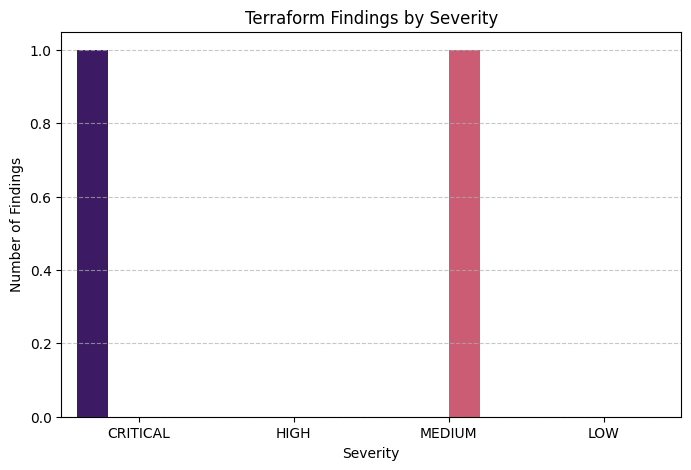

In [17]:
import pandas as pd
import json
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Define the path to the scans/terraform_findings.json file
terraform_findings_path = pathlib.Path("_ci_out/scans/terraform_findings.json")

# Check if the file exists before proceeding
if terraform_findings_path.exists():
    # 3. Load the JSON data from the file into a Python list of dictionaries
    with open(terraform_findings_path, 'r') as f:
        terraform_findings_data = json.load(f)

    # 4. Create a pandas DataFrame named df_terraform_findings from this list
    df_terraform_findings = pd.DataFrame(terraform_findings_data)
    print("DataFrame loaded successfully. Displaying the first 5 rows:")
    display(df_terraform_findings.head())

    # 5. Count the occurrences of each unique value in the 'severity' column
    severity_counts_tf = df_terraform_findings['severity'].value_counts().reset_index()
    severity_counts_tf.columns = ['severity', 'count']

    # 6. Define a custom order for the 'severity' column for better visualization
    severity_order_tf = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
    severity_counts_tf['severity'] = pd.Categorical(severity_counts_tf['severity'], categories=severity_order_tf, ordered=True)
    severity_counts_tf = severity_counts_tf.sort_values('severity')

    # 7. Create a bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='severity', y='count', hue='severity', data=severity_counts_tf, palette='magma', legend=False)

    # 8. Add a title to the plot
    plt.title('Terraform Findings by Severity')

    # 9. Label the x-axis and y-axis
    plt.xlabel('Severity')
    plt.ylabel('Number of Findings')

    # 10. Add a grid to the y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 11. Display the plot
    plt.show()
else:
    print(f"Error: File not found at {terraform_findings_path.as_posix()}")

## Visualize Serverless Findings by Function and Severity


 - Create a stacked bar chart to visualize the distribution of security findings by severity for each serverless function. This will help identify which functions have the most critical issues at a glance.


- To visualize the distribution of security findings by severity for each serverless function, I will first group the data by function and severity, then pivot it to create a suitable format for a stacked bar chart. Finally, I will generate the stacked bar chart as per the instructions.



<Figure size 1200x700 with 0 Axes>

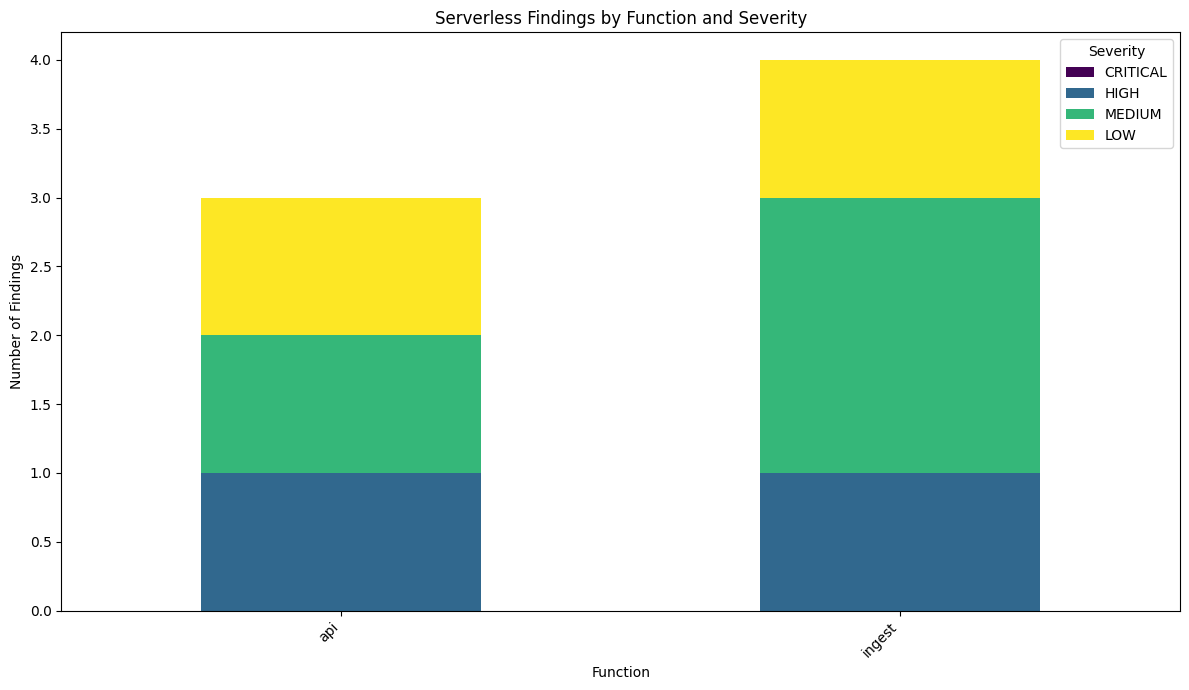

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Group the df_serverless_findings DataFrame by 'function' and 'severity', and then count the occurrences of each group.
function_severity_counts = df_serverless_findings.groupby(['function', 'severity']).size().reset_index(name='count')

# 2. Pivot the resulting DataFrame
pivoted_counts = function_severity_counts.pivot(index='function', columns='severity', values='count').fillna(0)

# 3. Define a consistent order for the severity levels and reindex the columns
severity_order_full = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
pivoted_counts = pivoted_counts.reindex(columns=severity_order_full, fill_value=0)

# 4. Create a stacked bar chart
plt.figure(figsize=(12, 7))
pivoted_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 7))

# 5. Add a title to the chart
plt.title('Serverless Findings by Function and Severity')

# 6. Label the x-axis and y-axis
plt.xlabel('Function')
plt.ylabel('Number of Findings')

# 7. Add a legend to differentiate the severity levels
plt.legend(title='Severity')

# Improve layout and display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Now I will create a stacked bar chart to visualize the distribution of security findings by severity for each Terraform resource type, following the same methodology as the serverless findings chart.



<Figure size 1200x700 with 0 Axes>

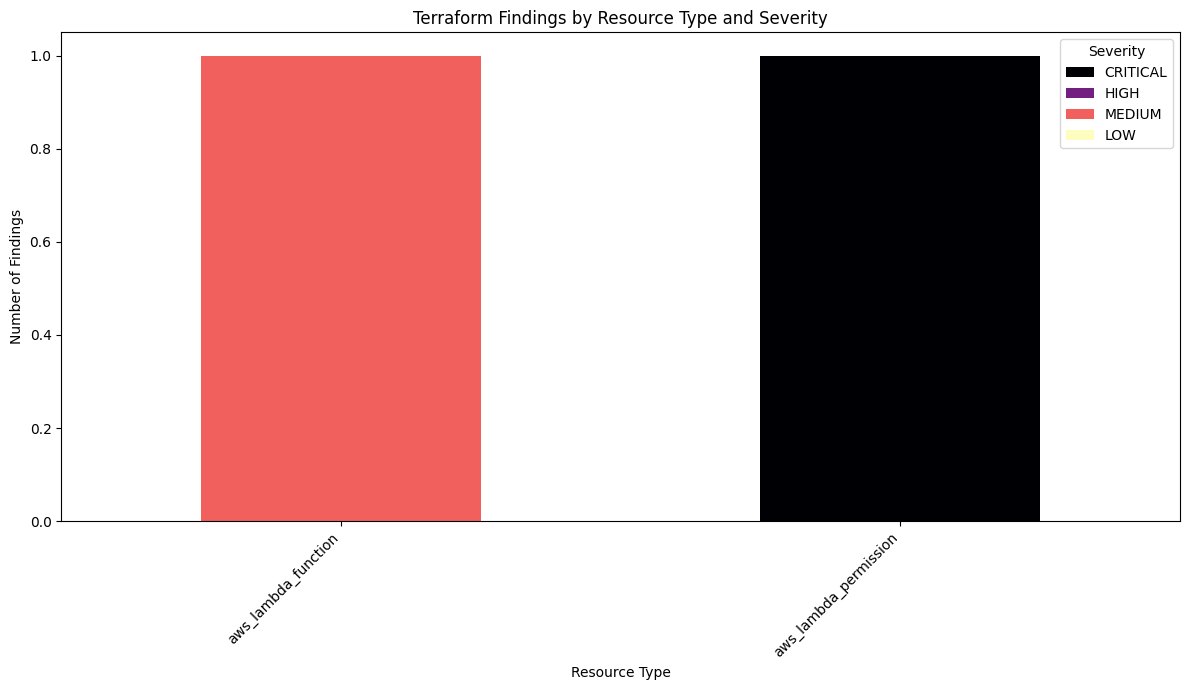

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Group the df_terraform_findings DataFrame by 'resource_type' and 'severity', and then count the occurrences of each group.
resource_type_severity_counts = df_terraform_findings.groupby(['resource_type', 'severity']).size().reset_index(name='count')

# 2. Pivot the resulting DataFrame
pivoted_counts_tf = resource_type_severity_counts.pivot(index='resource_type', columns='severity', values='count').fillna(0)

# 3. Define a consistent order for the severity levels and reindex the columns
severity_order_full = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
pivoted_counts_tf = pivoted_counts_tf.reindex(columns=severity_order_full, fill_value=0)

# 4. Create a stacked bar chart
plt.figure(figsize=(12, 7))
pivoted_counts_tf.plot(kind='bar', stacked=True, colormap='magma', figsize=(12, 7))

# 5. Add a title to the chart
plt.title('Terraform Findings by Resource Type and Severity')

# 6. Label the x-axis and y-axis
plt.xlabel('Resource Type')
plt.ylabel('Number of Findings')

# 7. Add a legend to differentiate the severity levels
plt.legend(title='Severity')

# Improve layout and display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Summary of Insights from Visualizations

The stacked bar charts provide a clear and concise overview of the security posture for both serverless functions and Terraform resources, broken down by severity.

**Serverless Findings by Function and Severity:**
*   The `ingest` function has a higher number of findings (4 total) compared to the `api` function (3 total).
*   Both functions exhibit 'HIGH' and 'MEDIUM' severity findings, with 'LOW' severity findings also present.
*   Specifically, the `ingest` function has two 'MEDIUM' severity findings, indicating areas like non-VPC attachment and event-triggered configurations that require attention.
*   The `api` function also has 'HIGH' and 'MEDIUM' severity issues, with the 'HIGH' severity likely pointing to the public invocation surface.
*   Neither function currently shows 'CRITICAL' severity findings based on the provided data.

**Terraform Findings by Resource Type and Severity:**
*   The `aws_lambda_permission` resource type has one 'CRITICAL' severity finding, which is a major concern (likely due to wildcarded principal for invocation).
*   The `aws_lambda_function` resource type has one 'MEDIUM' severity finding, indicating a potential issue such as lack of VPC attachment.
*   The visualization clearly highlights that the `aws_lambda_permission` is the most problematic resource from a severity standpoint.

**Overall Security Posture:**
*   The environment has a mix of 'CRITICAL', 'HIGH', 'MEDIUM', and 'LOW' severity findings across serverless functions and Terraform resources.
*   'CRITICAL' findings are specifically associated with `aws_lambda_permission`, demanding immediate attention due to the high risk of unauthorized access.
*   'HIGH' severity findings are present in both `ingest` and `api` serverless functions, likely related to secret exposure and public API exposure, respectively.
*   'MEDIUM' and 'LOW' findings indicate areas for improvement in network configuration, logging, and general best practices.

These visualizations help in quickly identifying the most vulnerable components and prioritizing remediation efforts based on severity and resource type/function.